## Data Intensive Computing Project: CSE 587

#### Problem Statement: Predicting average price of a used car by  using historical data

#### Type of problem: Supervised Learning, Regression problem

In [1]:
%%html
<style>
    div.output_stderr {
    display: none;
}
</style>

### Half of the analysis is in Pyspark and due to version constraints, rest is in Pandas. By the end of the project we will put entire code in either Pyspark or Pandas
For Pyspark -> please do `pip install pyspark` before running jupyter notebook

In [2]:
# Importing libraries and creating Spark Session
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

import pyspark.sql.functions as F
import pyspark.sql.types as T

import matplotlib.pyplot as plt
import pandas as pd

# Creating Spark Session
spark = SparkSession \
            .builder \
            .appName("DIC_Project_Phase1") \
            .getOrCreate()

23/10/10 23:04:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# Loading data from csv file
cars_df = spark \
            .read \
            .option("inferSchema", "true") \
            .option("header", "true") \
            .csv("autos.csv")

cars_df.printSchema()

[Stage 1:=======>                                                   (1 + 7) / 8]

root
 |-- dateCrawled: timestamp (nullable = true)
 |-- name: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- offerType: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- abtest: string (nullable = true)
 |-- vehicleType: string (nullable = true)
 |-- yearOfRegistration: integer (nullable = true)
 |-- gearbox: string (nullable = true)
 |-- powerPS: integer (nullable = true)
 |-- model: string (nullable = true)
 |-- kilometer: integer (nullable = true)
 |-- monthOfRegistration: integer (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- notRepairedDamage: string (nullable = true)
 |-- dateCreated: timestamp (nullable = true)
 |-- nrOfPictures: integer (nullable = true)
 |-- postalCode: integer (nullable = true)
 |-- lastSeen: timestamp (nullable = true)



### Some information about the dataset

In [4]:
print("Some Information about the dataset:")
print(f"Shape of raw dataset: {cars_df.count(), len(cars_df.columns)}\n")
print(f"Feature Columns: {cars_df.columns}\n")

# Here price column is not feature, its a dependent variable.

Some Information about the dataset:
Shape of raw dataset: (371824, 20)

Feature Columns: ['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen']



## Data Cleaning

### Data Quality check and Data Cleaning steps:
1. Feature selection - removing date crawled and other unnecessary features
2. Handling null values
3. Removing duplicate records
4. Resolving schema inconsistencies
5. Handling outliers
6. Handling inconsistencies in features
7. Feature Extraction -> how old is the car
8. Filtering out all observations where car is more than 20 years old
9. Normalizing data
10. Check for 0 values in features and again doing Feature Selection
11. Replacing mixture of german and english words features to english
12. Encoding categorical values

In [5]:
# Step 1
# Feature selection - removing date crawled and other unnecessary features
# Removing dateCrawled, and month of Registration features
features_to_select = [
    "name", 
    "seller", 
    "offerType", 
    "price", 
    "abtest", 
    "vehicleType", 
    "yearOfRegistration", 
    "gearbox", 
    "powerPS", 
    "model", 
    "kilometer", 
    "fuelType", 
    "brand", 
    "notRepairedDamage", 
    "dateCreated", 
    "nrOfPictures", 
    "postalCode", 
    "lastSeen"
]

filtered_cars_df = cars_df.select(features_to_select)
print(filtered_cars_df.printSchema(), filtered_cars_df.count())


root
 |-- name: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- offerType: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- abtest: string (nullable = true)
 |-- vehicleType: string (nullable = true)
 |-- yearOfRegistration: integer (nullable = true)
 |-- gearbox: string (nullable = true)
 |-- powerPS: integer (nullable = true)
 |-- model: string (nullable = true)
 |-- kilometer: integer (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- notRepairedDamage: string (nullable = true)
 |-- dateCreated: timestamp (nullable = true)
 |-- nrOfPictures: integer (nullable = true)
 |-- postalCode: integer (nullable = true)
 |-- lastSeen: timestamp (nullable = true)

None 371824


In [6]:
# Step 2
# Removing rows having null values in any column
cars_df_without_null = filtered_cars_df.na.drop()
print(f"Number of rows in original dataset: {filtered_cars_df.count()}")
print(f"Number of rows after removing all rows having null value in any column: {cars_df_without_null.count()}")


Number of rows in original dataset: 371824


[Stage 8:=======>                                                   (1 + 7) / 8]

Number of rows after removing all rows having null value in any column: 261161


In [7]:
# Step 3
# Removing duplicate records
cars_df_without_duplicate = cars_df_without_null.dropDuplicates()
print(f"Number of rows after removing duplicate records: {cars_df_without_duplicate.count()}")


[Stage 11:=========================================>            (155 + 8) / 200]

Number of rows after removing duplicate records: 261139


In [8]:
# Step 4
# Resolving Schema - making price column as float or decimal
cars_df_with_float_price = cars_df_without_duplicate \
                    .withColumn("price", cars_df_without_duplicate["price"].cast(T.DoubleType()).alias("price"))

cars_df_with_float_price.printSchema()


root
 |-- name: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- offerType: string (nullable = true)
 |-- price: double (nullable = true)
 |-- abtest: string (nullable = true)
 |-- vehicleType: string (nullable = true)
 |-- yearOfRegistration: integer (nullable = true)
 |-- gearbox: string (nullable = true)
 |-- powerPS: integer (nullable = true)
 |-- model: string (nullable = true)
 |-- kilometer: integer (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- notRepairedDamage: string (nullable = true)
 |-- dateCreated: timestamp (nullable = true)
 |-- nrOfPictures: integer (nullable = true)
 |-- postalCode: integer (nullable = true)
 |-- lastSeen: timestamp (nullable = true)



In [9]:
# Step 5
# Checking and removing outliers for - 
def remove_outliers_using_iqr(df, columns, factor=1.5):
    """
    Detects and treats outliers using IQR for multiple variables in a PySpark DataFrame.

    :param df: The input PySpark DataFrame
    :param columns: A list of columns to apply IQR outlier treatment
    :param factor: The IQR factor to use for detecting outliers (default is 1.5)
    :return: The processed DataFrame without outliers
    """
    for column in columns:
        # Calculating lower range and upper range, and IQR
        quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1

        # Define the upper and lower bounds for outliers
        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr

        # Filter outliers and update the DataFrame
        df = df.filter((F.col(column) >= lower_bound) & (F.col(column) <= upper_bound))

    return df


columns_to_check_outliers = ["price", "nrofpictures", "kilometer", "powerps"]
cars_df_without_outliers = remove_outliers_using_iqr(cars_df_with_float_price, columns_to_check_outliers, factor=1.5)
print(f"Number of observations left after removing outliers: {cars_df_without_outliers.count()}")


[Stage 25:==============>                                           (2 + 6) / 8]

Number of observations left after removing outliers: 201762


In [10]:
# Step 6
# Handling inconsistencies in features - 
# Changing values of 2 features from German to English
#   1. offerType - `Gesuch` and `Angebot` which means `request` and `listing`
#   2. notRepairedDamage - "ja" and "nein" which means `yes` and `no`

def replace_feature_values(df, feature_name, old_value, new_value):
    df = df.withColumn(feature_name, 
                       F.when(df[feature_name] == old_value, new_value)
                        .otherwise(df[feature_name]))
    
    return df

cars_df_with_consistent_values = replace_feature_values(
    cars_df_without_outliers,
    "offerType",
    "Gesuch",
    "request"
)

cars_df_with_consistent_values = replace_feature_values(
    cars_df_with_consistent_values,
    "offerType",
    "Angebot",
    "listing"
)

cars_df_with_consistent_values = replace_feature_values(
    cars_df_with_consistent_values,
    "notRepairedDamage",
    "ja",
    "yes"
)

cars_df_with_consistent_values = replace_feature_values(
    cars_df_with_consistent_values,
    "notRepairedDamage",
    "nein",
    "no"
)
print(cars_df_with_consistent_values.select("offerType").distinct().show())
print(cars_df_with_consistent_values.select("notRepairedDamage").distinct().show())
cars_df_with_consistent_values.printSchema()



+---------+
|offerType|
+---------+
|  listing|
|  request|
+---------+

None


+-----------------+
|notRepairedDamage|
+-----------------+
|               no|
|              yes|
+-----------------+

None
root
 |-- name: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- offerType: string (nullable = true)
 |-- price: double (nullable = true)
 |-- abtest: string (nullable = true)
 |-- vehicleType: string (nullable = true)
 |-- yearOfRegistration: integer (nullable = true)
 |-- gearbox: string (nullable = true)
 |-- powerPS: integer (nullable = true)
 |-- model: string (nullable = true)
 |-- kilometer: integer (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- notRepairedDamage: string (nullable = true)
 |-- dateCreated: timestamp (nullable = true)
 |-- nrOfPictures: integer (nullable = true)
 |-- postalCode: integer (nullable = true)
 |-- lastSeen: timestamp (nullable = true)



In [11]:
# Step 7
# Feature Extraction - Creating new features which is how old is car
# We will create this feature by subtracting `lastSeen` - `yearOfRegistration`

print(cars_df_with_consistent_values.select(["yearOfRegistration", "lastSeen"]).show(10))
cars_df_with_extracted_feature = cars_df_with_consistent_values \
                                    .withColumn("lastSeen_year", F.year("lastSeen"))



print(cars_df_with_extracted_feature.select(["yearOfRegistration", "lastSeen", "lastSeen_year"]).show(10))


cars_df_with_extracted_feature = cars_df_with_extracted_feature \
                                    .withColumn("age_of_car", (F.col("lastSeen_year") - F.col("yearOfRegistration")))

print(cars_df_with_extracted_feature.select(["yearOfRegistration", "lastSeen", "lastSeen_year", "age_of_car"]).show(10))


+------------------+-------------------+
|yearOfRegistration|           lastSeen|
+------------------+-------------------+
|              1997|2016-04-07 12:45:02|
|              1999|2016-04-07 10:17:16|
|              2007|2016-03-26 15:16:14|
|              1998|2016-04-06 17:46:14|
|              2004|2016-04-06 03:17:34|
|              1997|2016-03-12 04:46:51|
|              1996|2016-03-06 03:44:30|
|              2008|2016-03-23 11:16:59|
|              1991|2016-04-06 02:15:30|
|              2001|2016-03-12 21:44:42|
+------------------+-------------------+
only showing top 10 rows

None


+------------------+-------------------+-------------+
|yearOfRegistration|           lastSeen|lastSeen_year|
+------------------+-------------------+-------------+
|              1997|2016-04-07 12:45:02|         2016|
|              1999|2016-04-07 10:17:16|         2016|
|              2007|2016-03-26 15:16:14|         2016|
|              1998|2016-04-06 17:46:14|         2016|
|              2004|2016-04-06 03:17:34|         2016|
|              1997|2016-03-12 04:46:51|         2016|
|              1996|2016-03-06 03:44:30|         2016|
|              2008|2016-03-23 11:16:59|         2016|
|              1991|2016-04-06 02:15:30|         2016|
|              2001|2016-03-12 21:44:42|         2016|
+------------------+-------------------+-------------+
only showing top 10 rows

None


[Stage 62:=======>                                                  (1 + 7) / 8]

+------------------+-------------------+-------------+----------+
|yearOfRegistration|           lastSeen|lastSeen_year|age_of_car|
+------------------+-------------------+-------------+----------+
|              1997|2016-04-07 12:45:02|         2016|        19|
|              1999|2016-04-07 10:17:16|         2016|        17|
|              2007|2016-03-26 15:16:14|         2016|         9|
|              1998|2016-04-06 17:46:14|         2016|        18|
|              2004|2016-04-06 03:17:34|         2016|        12|
|              1997|2016-03-12 04:46:51|         2016|        19|
|              1996|2016-03-06 03:44:30|         2016|        20|
|              2008|2016-03-23 11:16:59|         2016|         8|
|              1991|2016-04-06 02:15:30|         2016|        25|
|              2001|2016-03-12 21:44:42|         2016|        15|
+------------------+-------------------+-------------+----------+
only showing top 10 rows

None


In [12]:
cars_df_with_extracted_feature.count()

201762

In [13]:
# Step 8
# Considering only last 20 years old cars

cars_df_20_years_old = cars_df_with_extracted_feature \
                        .filter(cars_df_with_extracted_feature["age_of_car"] <= 20)


print(cars_df_20_years_old.printSchema(), cars_df_20_years_old.count())

root
 |-- name: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- offerType: string (nullable = true)
 |-- price: double (nullable = true)
 |-- abtest: string (nullable = true)
 |-- vehicleType: string (nullable = true)
 |-- yearOfRegistration: integer (nullable = true)
 |-- gearbox: string (nullable = true)
 |-- powerPS: integer (nullable = true)
 |-- model: string (nullable = true)
 |-- kilometer: integer (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- notRepairedDamage: string (nullable = true)
 |-- dateCreated: timestamp (nullable = true)
 |-- nrOfPictures: integer (nullable = true)
 |-- postalCode: integer (nullable = true)
 |-- lastSeen: timestamp (nullable = true)
 |-- lastSeen_year: integer (nullable = true)
 |-- age_of_car: integer (nullable = true)



[Stage 68:===================================>                  (133 + 8) / 200]

None 183480


In [14]:
# Convertiing spark dataframe to pandas for further analysis
cars_df_20_years_old = cars_df_20_years_old.toPandas()

In [15]:
cars_df_20_years_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183480 entries, 0 to 183479
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   name                183480 non-null  object        
 1   seller              183480 non-null  object        
 2   offerType           183480 non-null  object        
 3   price               183480 non-null  float64       
 4   abtest              183480 non-null  object        
 5   vehicleType         183480 non-null  object        
 6   yearOfRegistration  183480 non-null  int32         
 7   gearbox             183480 non-null  object        
 8   powerPS             183480 non-null  int32         
 9   model               183480 non-null  object        
 10  kilometer           183480 non-null  int32         
 11  fuelType            183480 non-null  object        
 12  brand               183480 non-null  object        
 13  notRepairedDamage   183480 no

In [16]:
# Step 9 
# Normalizing numeric features
# For this dataset we need to normalize `powerps` and `kilometer` features

from sklearn.preprocessing import MinMaxScaler 


scaler = MinMaxScaler()
cars_df_scaled = cars_df_20_years_old
cars_df_scaled[["powerPS_scaled"]] = scaler.fit_transform(cars_df_20_years_old[["powerPS"]])
cars_df_scaled[["kilometer_scaled"]] = scaler.fit_transform(cars_df_20_years_old[["kilometer"]])

print(cars_df_scaled.head())
print(cars_df_scaled.info())
print(len(cars_df_scaled))

                                              name  seller offerType   price  \
0                                  Golf_1_6_Family  privat   listing   550.0   
1                       Ford_Focus_Turnier_DI_Ghia  privat   listing  1599.0   
2  ***VOLKSWAGEN_GOLF_5___V___TDI_SEHR_GEPFLEGT***  privat   listing  4500.0   
3                              Mercedes_Benz_E_240  privat   listing  2599.0   
4                          Ford_Transit_280_K_TDCi  privat   listing  3300.0   

    abtest vehicleType  yearOfRegistration  gearbox  powerPS     model  ...  \
0  control      andere                1997  manuell       75      golf  ...   
1     test       kombi                1999  manuell       90     focus  ...   
2     test   limousine                2007  manuell       90      golf  ...   
3     test   limousine                1998  manuell      170  e_klasse  ...   
4     test         bus                2004  manuell        0   transit  ...   

           brand notRepairedDamage dateCreat

In [17]:
# Step 10
# Removing bad values from features and one column `nrofpictures` has all values as 0, so we can drop that column
print(cars_df_scaled["name"].unique())
print(cars_df_scaled["nrOfPictures"].unique())


['Golf_1_6_Family' 'Ford_Focus_Turnier_DI_Ghia'
 '***VOLKSWAGEN_GOLF_5___V___TDI_SEHR_GEPFLEGT***' ...
 'Hier_Verkaufe_Auto_Seat_Alambra.Bj_2003_T�V/AU_bis_01.2018'
 'Peugeot_206_eco_HDi_90' 'Peugeot_306_Presence']
[0]


In [18]:
# As we can see there are **, ? etc in the `names`, we can try to remove as much as we can
# Also we can drop `nrOfPictures` column, since all values are 0
cars_df_scaled["name"] = cars_df_scaled["name"].str.replace('[^a-zA-Z0-9]', ' ')
print(cars_df_scaled["name"].unique())


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


['Golf 1 6 Family' 'Ford Focus Turnier DI Ghia'
 '   VOLKSWAGEN GOLF 5   V   TDI SEHR GEPFLEGT   ' ...
 'Hier Verkaufe Auto Seat Alambra Bj 2003 T V AU bis 01 2018'
 'Peugeot 206 eco HDi 90' 'Peugeot 306 Presence']


### Some more columns has german values

In [19]:
print(cars_df_scaled["seller"].unique())
print(cars_df_scaled["vehicleType"].unique())
print(cars_df_scaled["fuelType"].unique())
print(cars_df_scaled["gearbox"].unique())


['privat' 'gewerblich']
['andere' 'kombi' 'limousine' 'bus' 'kleinwagen' 'cabrio' 'coupe' 'suv']
['benzin' 'diesel' 'lpg' 'cng' 'hybrid' 'elektro' 'andere']
['manuell' 'automatik']


In [20]:
# Cleaning above mentioned features and changing it from German to English
cars_df_scaled["seller"] = cars_df_scaled["seller"].replace(["privat"], "private")
cars_df_scaled["seller"] = cars_df_scaled["seller"].replace(["gewerblich"], "commercial")

cars_df_scaled["vehicleType"] = cars_df_scaled["vehicleType"].replace(["andere"], "others")

cars_df_scaled["fuelType"] = cars_df_scaled["fuelType"].replace(["andere"], "others")
cars_df_scaled["fuelType"] = cars_df_scaled["fuelType"].replace(["benzin"], "benzine")
cars_df_scaled["fuelType"] = cars_df_scaled["fuelType"].replace(["elektro"], "electric")

cars_df_scaled["gearbox"] = cars_df_scaled["gearbox"].replace(["manuell"], "manual")
cars_df_scaled["gearbox"] = cars_df_scaled["gearbox"].replace(["automatik"], "automatic")

print(cars_df_scaled["seller"].unique())
print(cars_df_scaled["vehicleType"].unique())
print(cars_df_scaled["fuelType"].unique())
print(cars_df_scaled["gearbox"].unique())


['private' 'commercial']
['others' 'kombi' 'limousine' 'bus' 'kleinwagen' 'cabrio' 'coupe' 'suv']
['benzine' 'diesel' 'lpg' 'cng' 'hybrid' 'electric' 'others']
['manual' 'automatic']


In [21]:
print(len(cars_df_scaled["name"].unique()))

104590


In [22]:
# Step 11
# Also we can drop `nrOfPictures` column, since all values are 0
# Final Feature Selection of relevant columns

# Name column is mostly dirty data and has 104k unique values which is not required for our prediction model
# because we can identify a car by its `model` name and `brand` name.

features_to_select = [
    "seller", 
    "offerType", 
    "abtest", 
    "vehicleType",
    "yearOfRegistration", 
    "gearbox", 
    "model", 
    "fuelType", 
    "brand", 
    "notRepairedDamage", 
    "lastSeen_year", 
    "age_of_car",
    "powerPS_scaled", 
    "kilometer_scaled",
    "price"
]
features_selected_cars_df = cars_df_scaled[features_to_select]
features_selected_cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183480 entries, 0 to 183479
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   seller              183480 non-null  object 
 1   offerType           183480 non-null  object 
 2   abtest              183480 non-null  object 
 3   vehicleType         183480 non-null  object 
 4   yearOfRegistration  183480 non-null  int32  
 5   gearbox             183480 non-null  object 
 6   model               183480 non-null  object 
 7   fuelType            183480 non-null  object 
 8   brand               183480 non-null  object 
 9   notRepairedDamage   183480 non-null  object 
 10  lastSeen_year       183480 non-null  int32  
 11  age_of_car          183480 non-null  int32  
 12  powerPS_scaled      183480 non-null  float64
 13  kilometer_scaled    183480 non-null  float64
 14  price               183480 non-null  float64
dtypes: float64(3), int32(3), object(9)

In [23]:
features_selected_cars_df.to_csv("cleaned_version2_used_cars.csv")

In [24]:
# Step 12
# Encoding categorical values
categorical_columns = [
    "seller", 
    "offerType",
    "abtest",
    "vehicleType",
    "gearbox",
    "model",
    "fuelType",
    "brand",
    "notRepairedDamage"
]

final_encoded_cars_df = pd.get_dummies(features_selected_cars_df, columns=categorical_columns)

final_encoded_cars_df.shape

(183480, 311)

In [25]:
"price" in (final_encoded_cars_df.columns)

True

## Exploratory Data Analysis (EDA)

For EDA I will be converting Spark Dataframe to Pandas

EDA and Data Cleaning go hand in hand, sometimes we do EDA first like visualizing sum of null values for each column and looking at outliers and then removing them, which is part of Data Cleaning, and sometimes Data Cleaning comes first like removing unwanted columns, follow consistency in the features, etc and then perform the EDA. It all depends on the dataset and problem statement.

Different analysis we performed on the dataset:
1. Summary of the dataset - Descriptive Data Analysis
1. Visualizing percentage of null values by each feature.
2. Box plots for visualing outliers for numeric features.

In [26]:
### Descriptive Analysis
cars_df_without_outliers.select(["yearofregistration", "powerps", "kilometer", "price", "nrOfPictures"]).describe().show()


[Stage 73:===============================>                      (118 + 8) / 200]

+-------+------------------+------------------+------------------+-----------------+------------+
|summary|yearofregistration|           powerps|         kilometer|            price|nrOfPictures|
+-------+------------------+------------------+------------------+-----------------+------------+
|  count|            201762|            201762|            201762|           201762|      201762|
|   mean|2002.0535531963403|115.45251335732199|141351.93941376475|4243.801176633856|         0.0|
| stddev| 5.455230430262008| 51.26899055425064|17354.046154660653|4049.118627443208|         0.0|
|    min|              1919|                 0|             90000|              0.0|           0|
|    max|              2018|               255|            150000|          20470.0|           0|
+-------+------------------+------------------+------------------+-----------------+------------+



In [27]:
cars_df.select(["yearofregistration", "powerps", "kilometer", "price", "nrOfPictures"]).describe().show()


[Stage 75:>                                                         (0 + 8) / 8]

+-------+------------------+------------------+------------------+------------------+------------+
|summary|yearofregistration|           powerps|         kilometer|             price|nrOfPictures|
+-------+------------------+------------------+------------------+------------------+------------+
|  count|            371823|            371823|            371823|            371823|      371823|
|   mean|2004.5767206439623|115.54146462160759|125618.56044408226|17286.338865535483|         0.0|
| stddev|  92.8299905430405|192.07254710096788|40111.620164944565|3586530.1840677853|         0.0|
|    min|              1000|                 0|              5000|                 0|           0|
|    max|              9999|             20000|            150000|        2147483647|           0|
+-------+------------------+------------------+------------------+------------------+------------+



In [28]:
cars_df.select("nrOfPictures").distinct().show()

+------------+
|nrOfPictures|
+------------+
|        null|
|           0|
+------------+



From the above summary we can notice few things: 

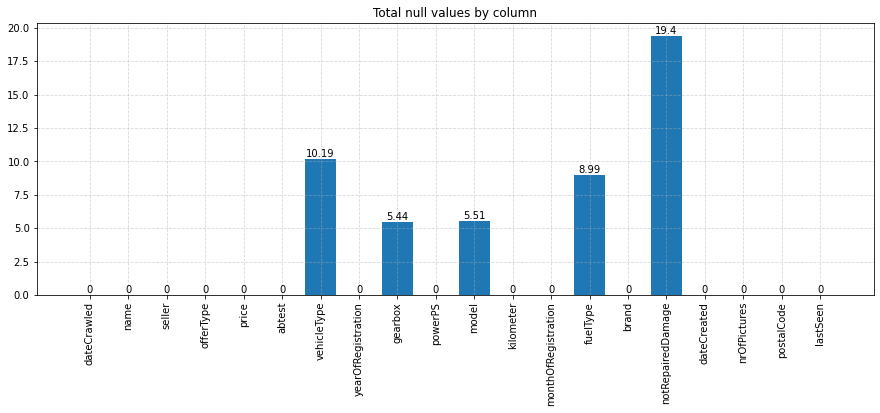

In [29]:
# Plotting average null values by each column
cars_df_count = cars_df.count()
null_counts = [round((cars_df.where(cars_df[col].isNull()).count() * 100 / cars_df_count), 2)  
                   for col in cars_df.columns
              ]

fig, ax = plt.subplots(figsize=[15, 5])
bars = ax.bar(x=cars_df.columns, height=null_counts)
ax.bar_label(bars)
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y')
plt.title("Total null values by column")
plt.grid(linestyle="dashed", alpha=0.5)
plt.show()

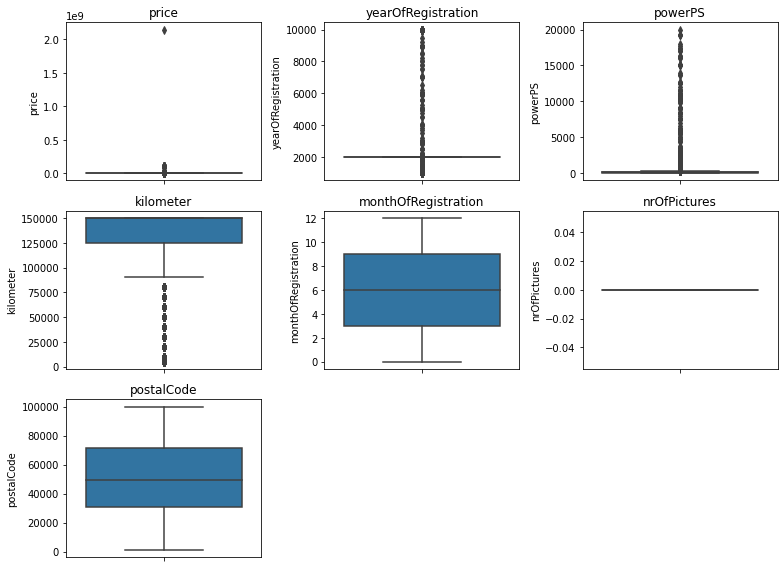

In [42]:
import seaborn as sns
# Detecting outliers by using boxplots
# Select numeric columns
numeric_cols = cars_df_pd.select_dtypes(include=[ 'float64']).columns

# Plot boxplots for each numeric column to visualize outliers
plt.figure(figsize=(11, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=cars_df_pd[col])
    plt.title(col)
    plt.tight_layout()

plt.show()

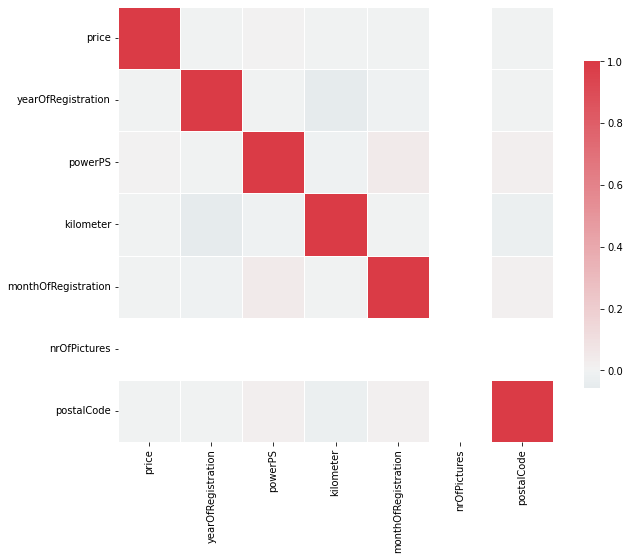

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis


#Making the subset of the data containing only the numeric values
numeric_subset = cars_df_pd.select_dtypes(include=['float64'])
#Normalizing the subset
scaler = StandardScaler()
numeric_subset_normalized = pd.DataFrame(scaler.fit_transform(numeric_subset), columns=numeric_subset.columns)
correlation_matrix = numeric_subset_normalized.corr()

price_correlation = correlation_matrix['price'].sort_values(ascending=False)

# Display the correlation of each feature with the price column
price_correlation


#Heatmap for the correlation matrix
plt.figure(figsize=(11, 8))
colors = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, cmap=colors, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": 0.75})

plt.show()

In [49]:
clean_data2=pd.read_csv ('cleaned_version2_used_cars.csv')

In [50]:
# Other metrics for descriptive analysis
from scipy.stats import skew, kurtosis
columns_to_analyze = ['powerPS_scaled','kilometer_scaled','price']

stats_data = {}
for col in columns_to_analyze:
    stats_data[col] = {
        'Mean': clean_data2[col].mean(),
        'Median': clean_data2[col].median(),
        'Mode': clean_data2[col].mode().iloc[0],
        'Variance': clean_data2[col].var(),
        'Standard Deviation': clean_data2[col].std(),
        'Skewness': skew(clean_data2[col]),
        'Kurtosis': kurtosis(clean_data2[col])
    }

# Convert results to a DataFrame for better visualization
stats_df = pd.DataFrame(stats_data)
stats_df

,powerPS_scaled,kilometer_scaled,price
Mean,0.458712,0.851896,4.423167e+03
Median,0.454902,1.000000,2.999000e+03
Mode,0.294118,1.000000,1.500000e+03
Variance,0.040281,0.085411,1.668325e+07
Standard Deviation,0.200701,0.292252,4.084513e+03
Skewness,0.101943,-1.842405,1.444346e+00
Kurtosis,-0.007981,2.095793,1.704304e+00


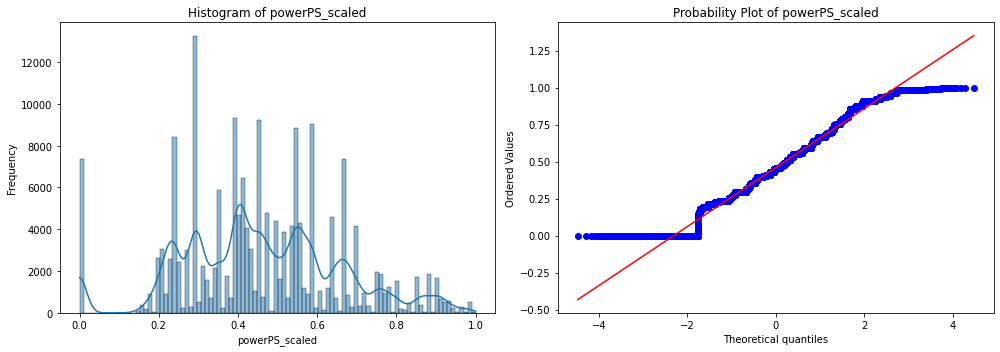

In [51]:
from scipy.stats import probplot

# Set up the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot histogram for powerPS_scaled
sns.histplot(clean_data2['powerPS_scaled'], kde=True, ax=ax[0])
ax[0].set_title('Histogram of powerPS_scaled')
ax[0].set_xlabel('powerPS_scaled')
ax[0].set_ylabel('Frequency')

# Plot Gaussian (probability) plot for powerPS_scaled
probplot(clean_data2['powerPS_scaled'], plot=ax[1])
ax[1].set_title('Probability Plot of powerPS_scaled')

plt.tight_layout()
plt.show()


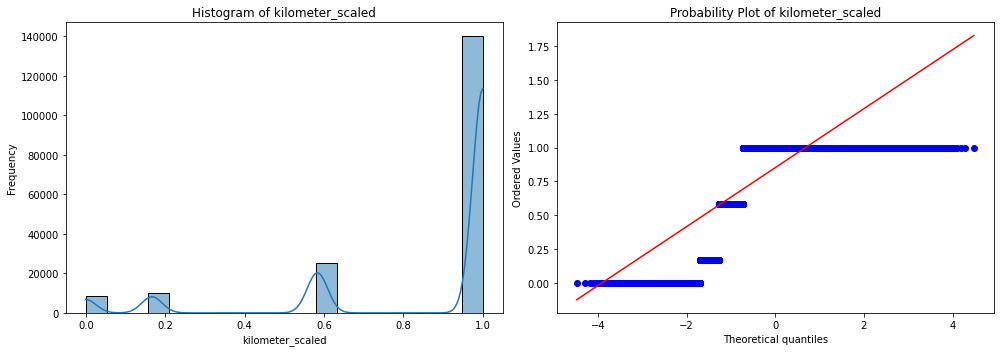

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot histogram for kilometer_scaled
sns.histplot(clean_data2['kilometer_scaled'], kde=True, ax=ax[0])
ax[0].set_title('Histogram of kilometer_scaled')
ax[0].set_xlabel('kilometer_scaled')
ax[0].set_ylabel('Frequency')

# Plot Gaussian (probability) plot for kilometer_scaled
probplot(clean_data2['kilometer_scaled'], plot=ax[1])
ax[1].set_title('Probability Plot of kilometer_scaled')

plt.tight_layout()
plt.show()

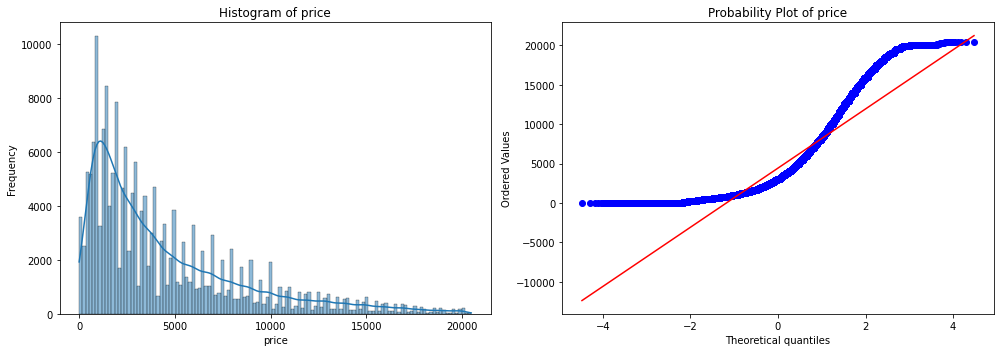

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot histogram for price
sns.histplot(clean_data2['price'], kde=True, ax=ax[0])
ax[0].set_title('Histogram of price')
ax[0].set_xlabel('price')
ax[0].set_ylabel('Frequency')

# Plot Gaussian (probability) plot for price
probplot(clean_data2['price'], plot=ax[1])
ax[1].set_title('Probability Plot of price')

plt.tight_layout()
plt.show()

In [54]:
#Making the subset of the data containing only the numeric values
columns_to_analyze = ['powerPS_scaled','kilometer_scaled','price']
#Normalizing the subset
scaler = StandardScaler()
numeric_subset_normalized = pd.DataFrame(scaler.fit_transform(numeric_subset), columns=numeric_subset.columns)
correlation_matrix = numeric_subset_normalized.corr()

price_correlation = correlation_matrix['price'].sort_values(ascending=False)

# Display the correlation of each feature with the price column
price_correlation

price                  1.000000
powerPS                0.006851
yearOfRegistration    -0.000182
kilometer             -0.000636
monthOfRegistration   -0.002825
postalCode            -0.003163
nrOfPictures                NaN
Name: price, dtype: float64

In [55]:
from sklearn.preprocessing import MinMaxScaler

# Columns to scale
cols_to_scale = ['powerPS_scaled', 'kilometer_scaled', 'price']

# Instantiate the scaler
scaler = MinMaxScaler()

# Scale the columns
data_scaled = clean_data2.copy()
data_scaled[cols_to_scale] = scaler.fit_transform(clean_data2[cols_to_scale])

# Display the first few rows of the scaled data
data_scaled[cols_to_scale].head()

,powerPS_scaled,kilometer_scaled,price
0,0.294118,1.0,0.026869
1,0.352941,1.0,0.078114
2,0.352941,1.0,0.219834
3,0.666667,1.0,0.126966
4,0.000000,1.0,0.161212


In [56]:
corr_matrix = data_scaled[cols_to_scale].corr()
corr_matrix

,powerPS_scaled,kilometer_scaled,price
powerPS_scaled,1.000000,0.055884,0.543115
kilometer_scaled,0.055884,1.000000,-0.252042
price,0.543115,-0.252042,1.000000


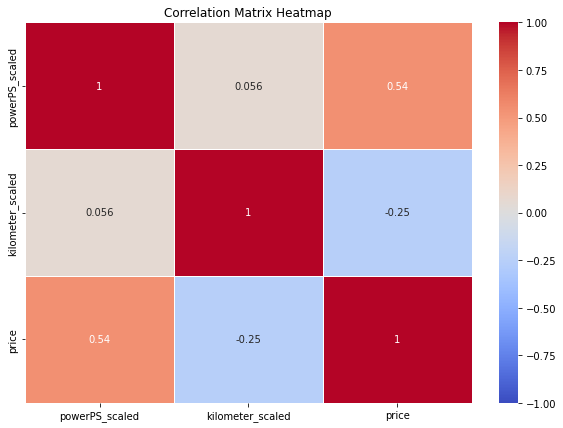

In [57]:
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

    From the above correlation metrix we can notice that `powerPS` is highly correlated with `price`

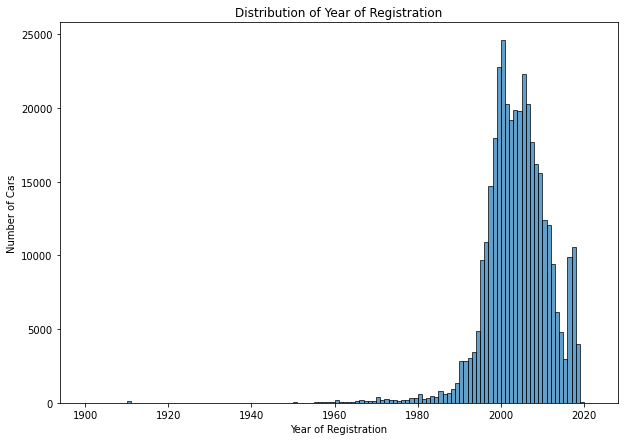

In [60]:
plt.figure(figsize=(10, 7))

plt.hist(cars_df_pd['yearOfRegistration'], bins=range(1900, 2023), edgecolor='black', alpha=0.7)
plt.title('Distribution of Year of Registration')
plt.xlabel('Year of Registration')
plt.ylabel('Number of Cars')
plt.show()


In [61]:
data = pd.read_csv ('cleaned_version2_used_cars.csv', encoding='ISO-8859-1')

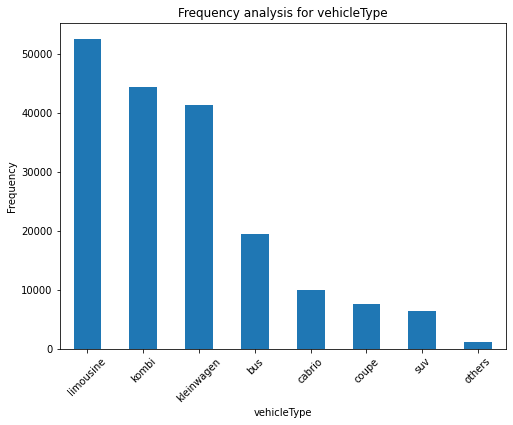

In [62]:
## Univariate

##VEHICLETYPE

frequency = data['vehicleType'].value_counts()
plt.figure(figsize=(8, 6))
frequency.plot(kind='bar')
plt.title(f"Frequency analysis for vehicleType")
plt.xlabel('vehicleType')
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

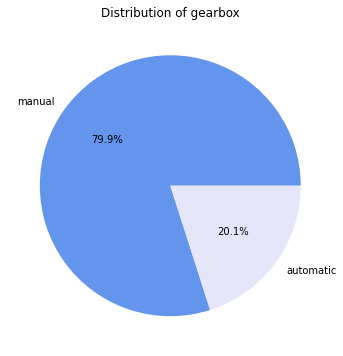

In [63]:
##GEARBOX

frequency = data['gearbox'].value_counts()
plt.figure(figsize=(8, 6))
colors = ['cornflowerblue', 'lavender']  # Define custom colors
frequency.plot(kind='pie', autopct='%1.1f%%', colors=colors)
plt.title(f"Distribution of gearbox")
plt.ylabel("")  # Remove the default 'gearbox' label
plt.show()

    From the above pie chart we can notice that manual cars are a lot more than automatic

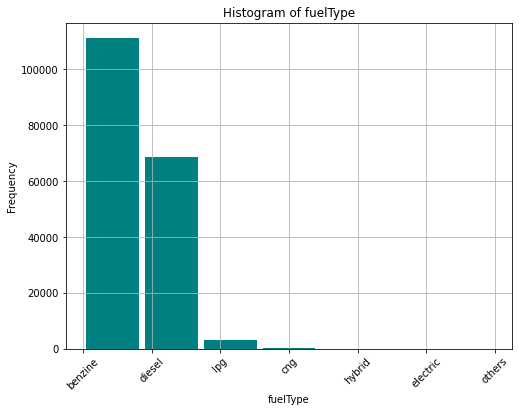

In [64]:
##FUELTYPE

data['fuelType'].hist(figsize=(8, 6), rwidth=0.9, bins=len(data['fuelType'].unique()), color='teal')
plt.title(f"Histogram of fuelType")
plt.xlabel('fuelType')
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

    From the above histogram we can notice that cars that runs on benzine are the most, followed by diesel and lpg.

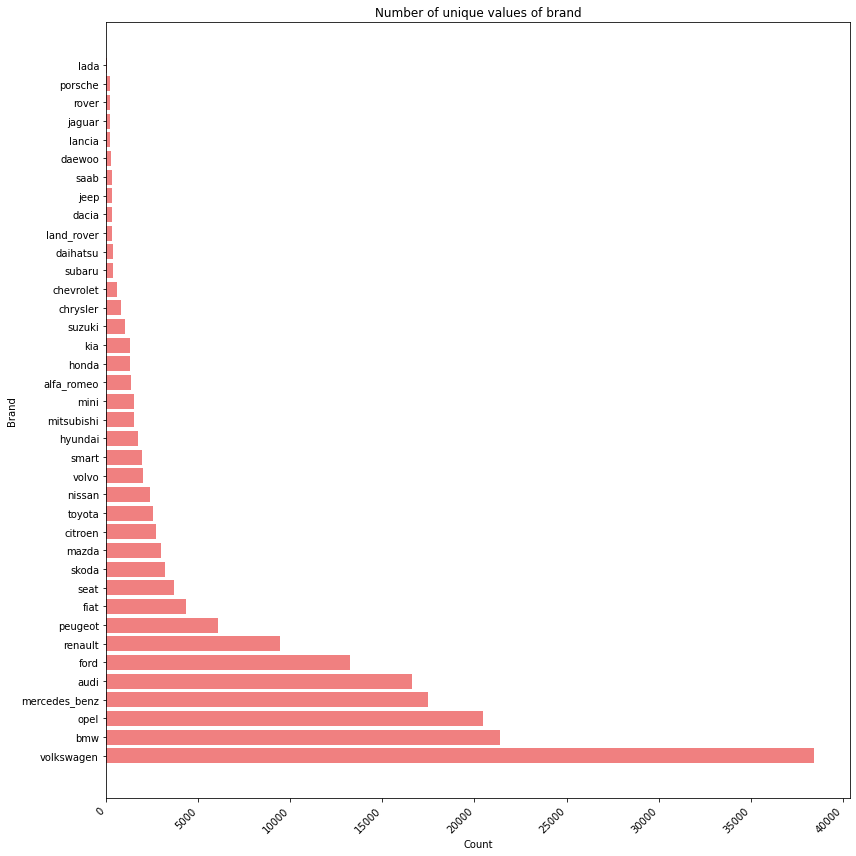

In [65]:
##BRAND

frequency = data['brand'].value_counts()
plt.figure(figsize=(12, 12))
plt.barh(frequency.index, frequency.values, color='lightcoral')  
plt.xticks(rotation=45, ha='right')
plt.title("Number of unique values of brand")
plt.xlabel("Count")
plt.ylabel("Brand")
plt.tight_layout()
plt.show()

    The above chart shows that number of observations of volkswagen is the most and lada, and porshe are the least

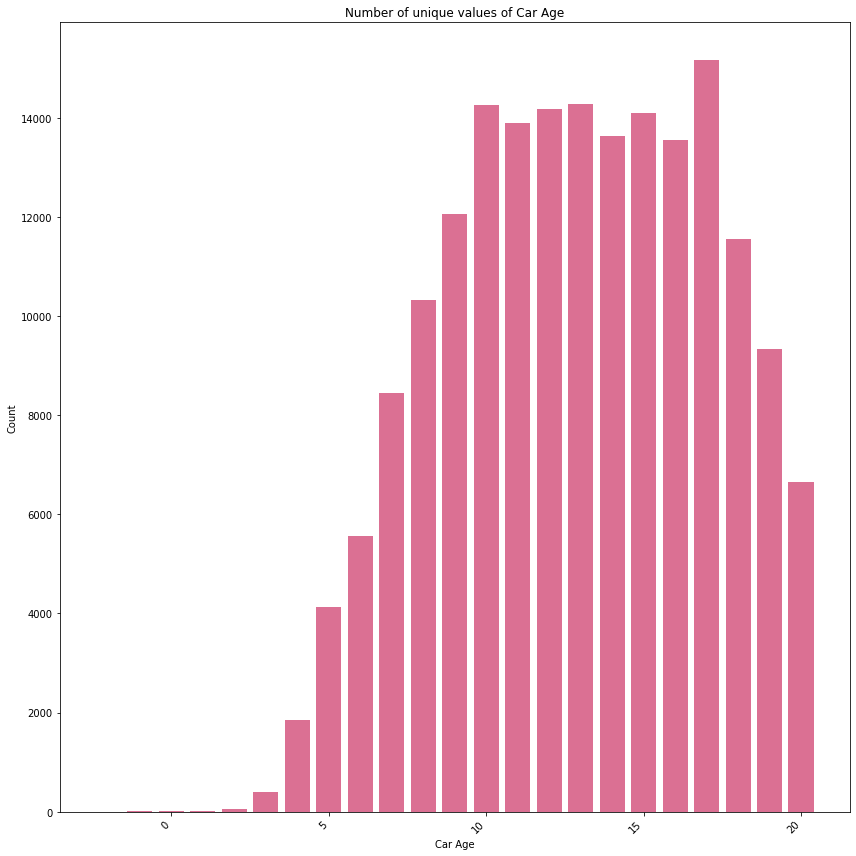

In [66]:
##AGE_OF_CAR

frequency = data['age_of_car'].value_counts()
plt.figure(figsize=(12, 12))
plt.bar(frequency.index, frequency.values, color='palevioletred')
plt.xticks(rotation=45, ha='right')
plt.title("Number of unique values of Car Age")
plt.ylabel("Count")
plt.xlabel("Car Age")
plt.tight_layout()
plt.show()


    The above chart shows that cars age between 10-16 years are most frequent ones.

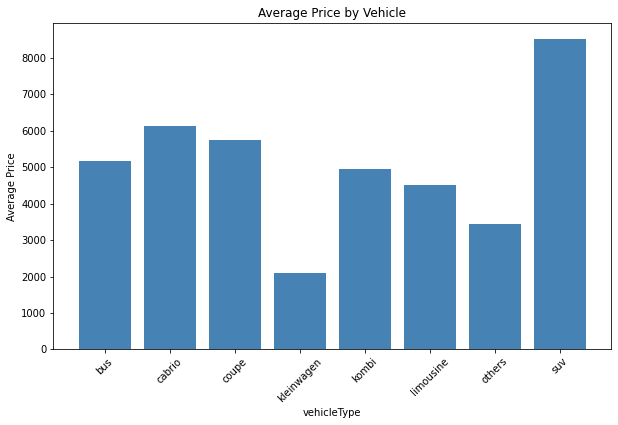

In [67]:
## VEHICLETYPE & AVERAGE PRICE

average_prices_by_vehicle = data.groupby('vehicleType')['price'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.bar(average_prices_by_vehicle['vehicleType'], average_prices_by_vehicle['price'], color='steelblue')
plt.xlabel('vehicleType')
plt.ylabel('Average Price')
plt.title('Average Price by Vehicle')
plt.xticks(rotation=45)
plt.show()

    Above chart shows that average price of SUVs are the most

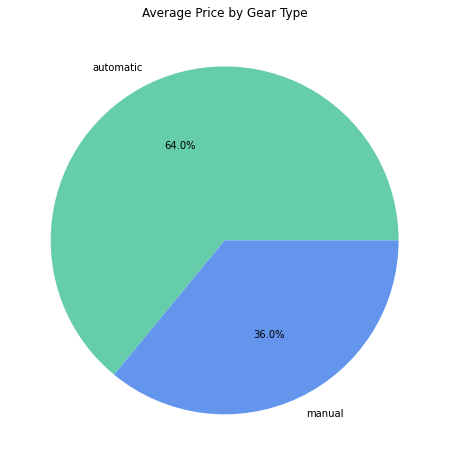

In [68]:
## GEARBOX TYPE & AVERAGE PRICE

average_prices_by_gearbox = data.groupby('gearbox')['price'].mean().reset_index()
colors = ['mediumaquamarine', 'cornflowerblue']
plt.figure(figsize=(8, 8))
plt.pie(average_prices_by_gearbox['price'], labels=average_prices_by_gearbox['gearbox'], colors=colors, autopct='%1.1f%%')
plt.title('Average Price by Gear Type')
plt.show()


    The above chart shows that the average price of automatic cars is way more than manual cars

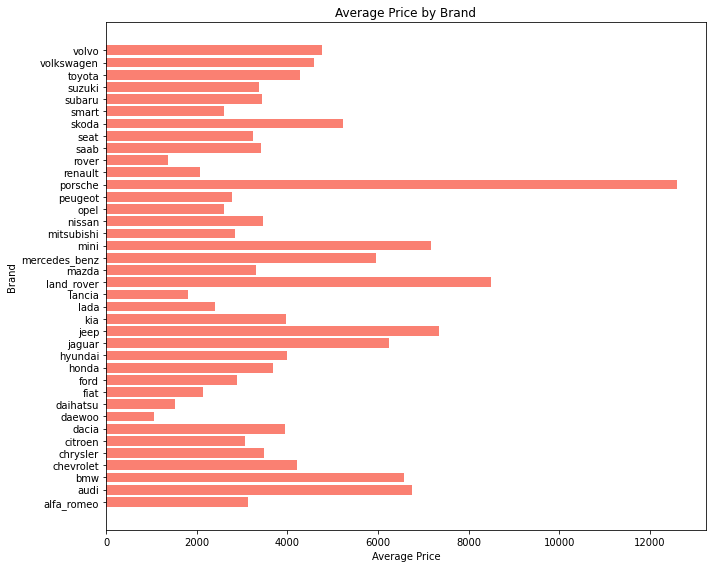

In [69]:
## BRAND & AVERAGE PRICE

average_prices_by_brand = data.groupby('brand')['price'].mean().reset_index()
plt.figure(figsize=(10, 8))
plt.barh(average_prices_by_brand['brand'], average_prices_by_brand['price'], color = 'salmon')
plt.ylabel('Brand')
plt.xlabel('Average Price')  
plt.title('Average Price by Brand')
plt.tight_layout()
plt.show()

    The above chart shows that the porshe has the most average price

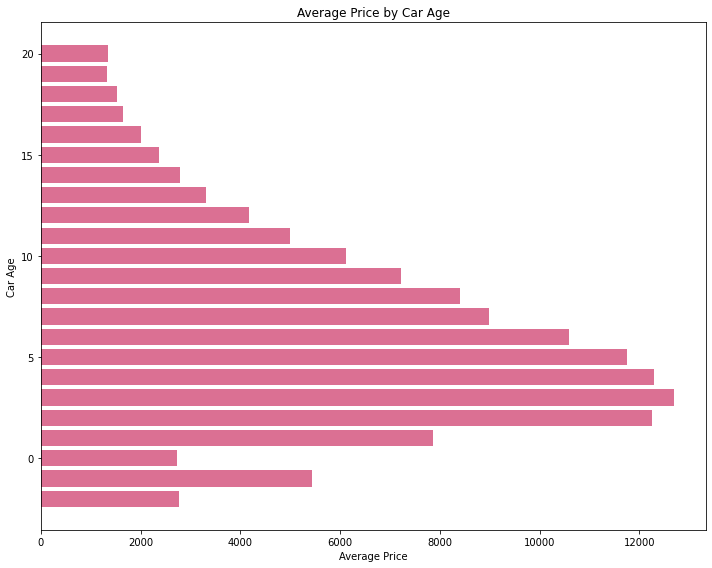

In [70]:
## AGE_OF_CAR & AVERAGE PRICE

average_prices_by_car_age = data.groupby('age_of_car')['price'].mean().reset_index()
plt.figure(figsize=(10, 8))
plt.barh(average_prices_by_car_age['age_of_car'], average_prices_by_car_age['price'], color='palevioletred') 
plt.xlabel('Average Price')
plt.ylabel('Car Age')
plt.title('Average Price by Car Age')
plt.tight_layout()
plt.show()

    The above chart shows that average price of cars having age between 1-6 years is the most